In [21]:
from mxnet import gluon
import mxnet as mx_net
import os
import numpy as np 
from mxnet import image
from mxnet import nd
from mxnet import init
from mxnet import cpu
import matplotlib as _plotlib
import matplotlib.pyplot as _pyplot
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxDetection
import time
ctx = mx_net.cpu()
#mean_rgb_value = nd.array([123, 117, 104])
mean_rgb_value = nd.array([123-55, 117-50, 104+60]) #检测大皮卡丘　pikachu27.png
mean_rgb_value = nd.array([123-20, 117+20, 104-40])
NumOfClass=1
NamesOfClass = ['pikachu'] #类名称
shape_dataset = 256

%matplotlib inline
_plotlib.rcParams['figure.dpi']= 120

def RectBox(Box_Rectangle, color, linewidth=3):
    #转换锚框成为rectangle
    Box_Rectangle = Box_Rectangle.asnumpy()
    return _pyplot.Rectangle(
        (Box_Rectangle[0], Box_Rectangle[1]), Box_Rectangle[2]-Box_Rectangle[0], Box_Rectangle[3]-Box_Rectangle[1],
        fill=False, edgecolor=color, linewidth=linewidth)

#预测物体的类别
def ClassPredictor(Anchors_Numbers, Classes_Numbers):
    #返回一个预测层
    return nn.Conv2D(Anchors_Numbers * (Classes_Numbers + 1), 3, padding=1)

#预测物体的边框
def YucheBox(Anchors_Numbers):
    #返回一个预测边框位置的网络
    return nn.Conv2D(Anchors_Numbers * 4, 3, padding=1)

#减半模块
def Reduce_Module(out_lays):
    #连接两个Conv-BatchNorm-Relu blocks和一个 pooling layer使得最后输出的特征减半
    outputs = nn.HybridSequential()
    for _ in range(2):
        outputs.add(nn.Conv2D(out_lays, 3, strides=1, padding=1))#输出　num_filters　个通道数
        outputs.add(nn.BatchNorm(in_channels=out_lays))#归一化
        outputs.add(nn.Activation('relu'))
    outputs.add(nn.MaxPool2D(2)) 
    return outputs

#将不同层的输出合并
def Fla_yuche(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def link_yuche(preds):
    return nd.concat(*preds, dim=1)

#主体网络
def main_body_net():
    outputs = nn.HybridSequential()
    for range_prediction in [16, 32, 64]:
        outputs.add(Reduce_Module(range_prediction))
    return outputs

#定义ssd模型
def SSD_Model(Anchors_Numbers, Classes_Numbers):
    ReduceSamplers = nn.Sequential()
    for _ in range(3):
        ReduceSamplers.add(Reduce_Module(128))
        
    ClassPred = nn.Sequential()
    Box_Pred = nn.Sequential()    
    for _ in range(5):
        ClassPred.add(ClassPredictor(Anchors_Numbers, Classes_Numbers))
        Box_Pred.add(YucheBox(Anchors_Numbers))

    All_Models = nn.Sequential()
    All_Models.add(main_body_net(), ReduceSamplers, ClassPred, Box_Pred)
    return All_Models

#计算预测
def SsdModelForward(x, All_Models, sizes, ratios, verbose=False):    
    main_body_net, ReduceSamplers, ClassPred, Box_Pred = All_Models
    output_anchors, output_class_preds, output_box_preds = [], [], []
    # feature extraction    
    x = main_body_net(x)#feature extraction完毕
    for i in range(5):
        # predict
        output_anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        output_class_preds.append(
            Fla_yuche(ClassPred[i](x)))
        output_box_preds.append(
            Fla_yuche(Box_Pred[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  output_anchors[-1].shape[1], 'output_anchors')
        # down sample
        if i < 3:
            x = ReduceSamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (link_yuche(output_anchors),
            link_yuche(output_class_preds),
            link_yuche(output_box_preds))

#完整的模型
class ToySSD(gluon.Block):
    def __init__(self, Classes_Numbers, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor Box_Rectangle sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.Classes_Numbers = Classes_Numbers
        self.verbose = verbose
        Anchors_Numbers = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.All_Models = SSD_Model(Anchors_Numbers, Classes_Numbers)

    def forward(self, x):
        output_anchors, output_class_preds, output_box_preds = SsdModelForward(
            x, self.All_Models, self.sizes, self.ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        output_class_preds = output_class_preds.reshape(shape=(0, -1, self.Classes_Numbers+1))
        return output_anchors, output_class_preds, output_box_preds
    
#预测初始化
os.makedirs('checkpoints',exist_ok=True)
filename = "checkpoints/testnet.params"
filename_2 = "checkpoints_2/ssd_net.params"
filename_3 = "checkpoints_3/ssd_net_3.params"
ctx = cpu(0)
#TrainData.reshape(label_shape=(3, 5))
#TrainData = TestData.sync_label_shape(TrainData)
net = ToySSD(NumOfClass)
net.load_params(filename_3, ctx=ctx)

#图像预处理
def img_Processor(file_name):
    with open(file_name, 'rb') as f:
        img = image.imdecode(f.read())
    # resize to shape_dataset
    data = image.imresize(img, shape_dataset, shape_dataset)
    # minus rgb mean
    data = data.astype('float32') - mean_rgb_value
    # convert to batch_test x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), img

#定义预测函数
def predict(x):
    output_anchors, output_class_preds, output_box_preds = net(x.as_in_context(ctx))
    output_class_probs = nd.SoftmaxActivation(
        output_class_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(output_class_probs, output_box_preds, output_anchors,force_suppress=True, clip=False)

#预测
path='../img/pikachu17.png'#threshold=0.51 pikachu6_2 pikachu16.png
path_2='../img/pikachu15.jpg'#threshold=0.45
path_3='../img/pikachu6_2.jpg'
tic = time.time()
x, img = img_Processor(path)
outputs = predict(x)
print("单次检测时间为：",(time.time()-tic))
#print(' time %.1f sec' % (time.time()-tic))
#outputs.shape





单次检测时间为： 0.007251739501953125


In [22]:
print(outputs[0][0:10])


[[ 0.          0.66010827  0.75127256  0.6281923   0.8999065   0.83385146]
 [ 0.          0.66000956  0.46285564  0.28008553  0.6098841   0.5069289 ]
 [ 0.          0.6300753   0.4216334   0.3486888   0.59148103  0.5846127 ]
 [ 0.          0.588361    0.43265706  0.48855007  0.58847696  0.72480166]
 [-1.          0.5766536   0.39907572  0.4740901   0.5860402   0.72529197]
 [ 0.          0.5401196   0.28843904  0.2086166   0.44149572  0.37891543]
 [-1.          0.5358271   0.4286693   0.4126004   0.58454895  0.695807  ]
 [-1.          0.53133756  0.46857244  0.27370906  0.6005495   0.4871121 ]
 [-1.          0.5261787   0.46056953  0.27743617  0.59356165  0.49056664]
 [-1.          0.52402574  0.4326953   0.46873993  0.59511393  0.7168779 ]]
<NDArray 10x6 @cpu(0)>


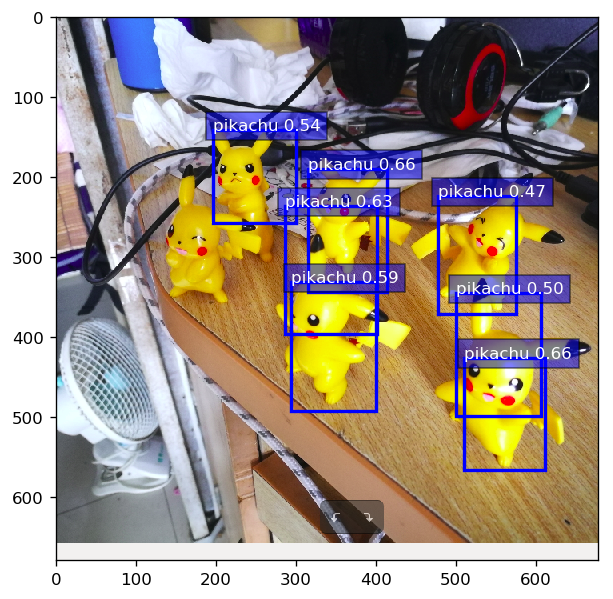

In [23]:
#显示输出
five_colors = ['blue', 'green', 'red', 'black', 'magenta']
_plotlib.rcParams['figure.figsize'] = (6,6)

def display_preds(img, outputs, threshold=0.5):    
    _pyplot.imshow(img.asnumpy())
    for rows in outputs:
        rows = rows.asnumpy()
        class_num_id, class_score = int(rows[0]), rows[1]
        if class_num_id < 0 or class_score < threshold:
            continue
        color = five_colors[class_num_id%len(five_colors)]#例如０％５＝０　１％５＝１　２％５＝２
        Box_Rectangle = rows[2:6] * np.array([img.shape[0],img.shape[1]]*2)
        rect = RectBox(nd.array(Box_Rectangle), color, 2)
        _pyplot.gca().add_patch(rect)
                        
        text = NamesOfClass[class_num_id]
        _pyplot.gca().text(Box_Rectangle[0], Box_Rectangle[1], 
                       '{:s} {:.2f}'.format(text, class_score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    _pyplot.show()

display_preds(img, outputs[0], threshold=0.43)